<a href="https://colab.research.google.com/github/TugaAhmed/ECoG_motor_imagery/blob/main/projects/Moter_Imagery_Classification_Pipline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install/Import Libraries 

!pip install EntropyHub --quiet
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

import numpy as np
from scipy.stats import entropy as en
import scipy.stats as scst
import EntropyHub as enh


import pickle as pickle
import pandas as pd
import math
import seaborn as sns

from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


import os
import time
import statistics as st
import scipy
from scipy.fftpack import *
from scipy.signal import hilbert, chirp
from scipy import signal


     |████████████████████████████████| 104 kB 8.5 MB/s 
     |████████████████████████████████| 64 kB 3.1 MB/s 
     |████████████████████████████████| 76 kB 5.0 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 9.6 MB 2.1 MB/s 
     |████████████████████████████████| 13.3 MB 7.8 MB/s 
     |████████████████████████████████| 3.2 MB 46.7 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 86 kB 4.0 MB/s 
     |████████████████████████████████| 179 kB 17.7 MB/s 


## **Motor Imagery Classification With Optimal Selection Of Minimum Electrode Subsets**

Group project developed by Chrysalis team, NMA 2022

**Pipeline :**


1. Data acquisition 
2. Data filtering/artifact removal
3. Epoching and Down-sampling
4. Feature Selection 
5. Model Fitting 
6. Channel Selection





In [2]:
#@title Feature Selection Methods

def ERD_feature(trial_task, trial_rest) :
  
  # Step1 : high-pass filter (above 8 Hz)
  b1, a1 = signal.butter(3, [8], btype='high', fs=1000)
  trial_rest_high_filtered = signal.filtfilt(b1, a1, trial_rest, 0)

  b2, a2 = signal.butter(3, [8], btype='high', fs=1000)
  trial_task_high_filtered = signal.filtfilt(b2, a2, trial_task, 0)

  # Step2 : low-pass filter (below 12 Hz)
  b1, a1 = signal.butter(3, [12], btype='low', fs=1000)
  trial_rest_bandpass_filtered = signal.filtfilt(b1, a1, trial_rest, 0)

  b2, a2 = signal.butter(3, [12], btype='low', fs=1000)
  trial_task_bandpass_filtered = signal.filtfilt(b2, a2, trial_task, 0)
  
  # Same time_window size for trial_task and trial_rest(can be different )
  time_window = trial_task.shape[0]  # One second or less for BCI application
  
  # Step3 : power_spectrum 
  rest_fourier_transform = np.fft.rfft(trial_rest_bandpass_filtered)
  rest_abs_fourier_transform = np.abs(rest_fourier_transform)
  rest_power_spectrum = np.square(rest_abs_fourier_transform)

  task_fourier_transform = np.fft.rfft(trial_task_bandpass_filtered)
  task_abs_fourier_transform = np.abs(task_fourier_transform)
  task_power_spectrum = np.square(task_abs_fourier_transform)

  # Step4: 
  # P_rest is the mean power spectra during the rest period 
  # P_task is the mean power spectra during the task period 

  p_rest = (1/time_window) * np.sum(rest_power_spectrum)
  p_task = (1/time_window) * np.sum(task_power_spectrum)

  # Step5: relative power (RP)

  RP = ((p_task - p_rest) / p_rest ) * 100
  
  return RP



def shannon_entropy_feature(trial) :
  square = np.power(trial,2)
  square_sum = np.sum(square)
  # energy Probability
  EP = square/square_sum
  # Shannon entropy
  SE = -np.sum(EP * np.log(np.power(EP,2)))
  return SE



def log_energy_entropy_feature(trial) :
  square = np.power(trial,2)
  square_sum = np.sum(square)
  # energy Probability
  EP = square/square_sum
  # LogEnergy entropy
  LEE = np.sum(EP * np.log(EP))
  return LEE



def hilbert_feature(trial) :
  analytic_signals = scipy.signal.hilbert(trial)
  amplitude_envelope = np.abs(analytic_signals)
  averaged_amplitude_envelope = amplitude_envelope.mean()
  return averaged_amplitude_envelope


def log_variance_feature(trial) :
  log_variance = np.log(np.var(trial))
  return log_variance


def std_feature(trial) :
  return np.std(trial)


def mean_feature(trial) :
  return np.mean(trial)





In [3]:
#@title 1. Data acquisition
# 1. Data acquisition
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

alldat = np.load(fname, allow_pickle=True)['dat']

In [4]:
#@title 2.Data filtering/artifact removal

def filter_EcoG_data(subject_number = 0 , experiment_number = 1) :
  '''
       input : 
        1. subject number - int value
        2. experiment number - int value
       return :
        filtred Voltage np array
  '''
  data = alldat[subject_number][experiment_number]  # Data from  first subject , second experiment(motor imagery)

  # V is the voltage data
  V = data['V'].astype('float32')

  # high-pass filter above 0.1 Hz
  b, a = signal.butter(3, [0.1], btype='high', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # low-pass filter above 45 Hz
  b, a = signal.butter(3, [45], btype='low', fs=1000)
  V = signal.filtfilt(b, a, V, 0)


  # Work on Notch Filtering @ 60 HZ
  fs = 1000.0  # Sample frequency (Hz)
  f0 = 60.0  # Frequency to be removed from signal (Hz)
  Q = 2.0  # Quality factor
  # Design notch filter
  b, a = signal.iirnotch(f0, Q, fs)
  NotchSignal60 = signal.filtfilt(b, a, V)


  # Work on Notch Filtering @ 120 HZ
  fs = 1000.0  # Sample frequency (Hz)
  f2 = 120.0  # Frequency to be removed from signal (Hz)
  Q = 2.0  # Quality factor
  # Design notch filter
  b, a = signal.iirnotch(f0, Q, fs)
  NotchSignal120 = signal.filtfilt(b, a, V)


  # normalize each channel so its mean power is 1
  V = V/V.mean(0)
  return V



In [5]:
#@title 3.Epoching and Down-Sampling



def epoching_down_sampling(filtered_V,subject_number=0,experiment_number=1,\
                           channels_list=[1] , sample_size = 1000) :
  '''
     input : 
         filtered voltage data - np array
         subject number - int
         experiment number - int
         channels list - list
         sample size  - int
    return :
         stacked array of all channels 
         1D array of labels 
  '''
  def get_labels_array(channels_list, subject_number , experiment_number) :
    stacked_labels = np.zeros(60*len(channels_list))
    
    for channel in range(len(channels_list)) :
      new_stim_id_array = np.zeros(60)
      for  i , stim_id in enumerate(alldat[subject_number][experiment_number]['stim_id']) :
        if stim_id == 11 :
          new_stim_id_array[i] = 0
        else :
          new_stim_id_array[i] = 1
      stacked_labels[60*channel:(60*channel) + 60 ] = new_stim_id_array
    return stacked_labels


  V_T = filtered_V.T
  channels_array_list = []
  t_on_array = alldat[subject_number][experiment_number]['t_on']
  t_off_array = alldat[subject_number][experiment_number]['t_off']
  step_size = (t_off_array[0] - t_on_array[0]) / sample_size

  for channel in channels_list :
    channel_array = V_T[channel][t_on_array[0] : t_off_array[0]-1][::int(step_size)]
    for t_on , t_off  in zip (t_on_array[1:] , t_off_array[1:]) :
      slice_v = V_T[channel][t_on : t_off-1][::int(step_size)]
      channel_array = np.vstack((channel_array,slice_v))
    channels_array_list.append(channel_array)
  
  all_channels_stacked_array = np.concatenate(channels_array_list , axis=0)

  labels = get_labels_array(channels_list , subject_number , experiment_number) 
  return all_channels_stacked_array , labels




In [6]:
#@title 4.Feature Selection

def feature_selection(all_channels_stacked_array) :
  '''
    Convert raw V to features 
    input :
      all channels stacked array
    return :
      X array(number of samples , number of features) as input to classifer
  '''

  # ERD_feature
  number_of_samples = all_channels_stacked_array.shape[0]
  mean_array = std_array = log_variance_array = hilbert_array =\
  log_energy_entropy_array = shannon_entropy_array = np.zeros(number_of_samples)

  for i , time_window in enumerate(all_channels_stacked_array) :
    mean_array[i] = mean_feature(time_window)
    std_array[i] = std_feature(time_window)
    log_variance_array[i] = log_variance_feature(time_window)
    hilbert_array[i] = hilbert_feature(time_window)
    log_energy_entropy_array[i] = log_energy_entropy_feature(time_window)
    shannon_entropy_array[i] = shannon_entropy_feature(time_window)
    


  # Features array as X input to classifer
  X = np.column_stack((mean_array,std_array,log_variance_array,hilbert_array\
                       ,log_energy_entropy_array,shannon_entropy_array))
  return X




In [7]:
V = filter_EcoG_data(subject_number=0,experiment_number=1)
V.shape

(376600, 46)

In [8]:
all_channels_stacked_array , labels= epoching_down_sampling(V,channels_list = [2] ,sample_size=1000)
all_channels_stacked_array.shape

(60, 1000)

In [9]:
labels.shape

(60,)

In [10]:
X = feature_selection(all_channels_stacked_array)
X.shape

(60, 6)

In [11]:
Y = labels
Y.shape

(60,)

In [58]:
# 5/ Model Fitting

# step(1):  devide X,Y into train - test set 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 101)

In [57]:
SVM_classifer = svm.SVC(gamma=0.001 , C=100 , kernel='linear')
SVM_classifer.fit(X_train, y_train)

SVC(C=100, gamma=0.001, kernel='linear')

In [59]:
y_pred = SVM_classifer.predict(X_test)

In [60]:
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

         0.0       0.41      1.00      0.58         7
         1.0       1.00      0.09      0.17        11

    accuracy                           0.44        18
   macro avg       0.71      0.55      0.38        18
weighted avg       0.77      0.44      0.33        18



In [63]:
#@title 4.Fitting kNN model
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, Y, test_size = 0.30, random_state = 123)
knn_model = KNeighborsRegressor(n_neighbors=3)

In [64]:
knn_model.fit(X_train_knn, y_train_knn)
train_preds_knn = knn_model.predict(X_train_knn)
mse = mean_squared_error(y_train_knn, train_preds_knn)
rmse = np.sqrt(mse)
rmse

0.5539659798925444

In [65]:
test_preds_knn = knn_model.predict(X_test_knn)
mse = mean_squared_error(y_test_knn, test_preds_knn)
rmse = np.sqrt(mse)
rmse

0.5211573066470477

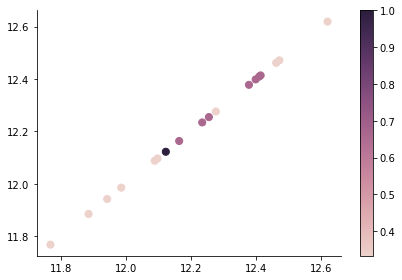

In [66]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(X_test_knn[:, 0], X_test_knn[:, 1], c=test_preds_knn, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

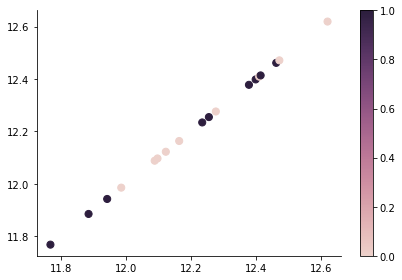

In [67]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(X_test_knn[:, 0], X_test_knn[:, 1], c=y_test_knn, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

In [69]:
parameters_knn = {"n_neighbors": range(1, 30)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters_knn, verbose=3)
gridsearch.fit(X_train_knn, y_train_knn)
gridsearch.best_params_

Fitting 5 folds for each of 29 candidates, totalling 145 fits
[CV 1/5] END ....................n_neighbors=1;, score=-2.214 total time=   0.0s
[CV 2/5] END ....................n_neighbors=1;, score=-1.250 total time=   0.0s
[CV 3/5] END ....................n_neighbors=1;, score=-2.333 total time=   0.0s
[CV 4/5] END ....................n_neighbors=1;, score=-2.000 total time=   0.0s
[CV 5/5] END ....................n_neighbors=1;, score=-1.000 total time=   0.0s
[CV 1/5] END ....................n_neighbors=2;, score=-0.446 total time=   0.0s
[CV 2/5] END ....................n_neighbors=2;, score=-1.250 total time=   0.0s
[CV 3/5] END ....................n_neighbors=2;, score=-2.000 total time=   0.0s
[CV 4/5] END .....................n_neighbors=2;, score=0.000 total time=   0.0s
[CV 5/5] END ....................n_neighbors=2;, score=-1.000 total time=   0.0s
[CV 1/5] END ....................n_neighbors=3;, score=-1.357 total time=   0.0s
[CV 2/5] END ....................n_neighbors=3;

{'n_neighbors': 25}

In [72]:
train_preds_grid_knn = gridsearch.predict(X_train_knn)
train_mse = mean_squared_error(y_train_knn, train_preds_grid_knn)
train_rmse = np.sqrt(train_mse)
test_preds_grid_knn = gridsearch.predict(X_test_knn)
test_mse = mean_squared_error(y_test_knn, test_preds_grid_knn)
test_rmse = np.sqrt(test_mse)
print(train_rmse)
print(test_rmse)

0.5022994743226016
0.49593906435726115


In [78]:
best_k = gridsearch.best_params_["n_neighbors"]
# best_weights = gridsearch.best_params_["weights"]
bagged_knn = KNeighborsRegressor(
    n_neighbors=best_k
)

In [79]:
from sklearn.ensemble import BaggingRegressor
bagging_model = BaggingRegressor(bagged_knn, n_estimators=100)
bagging_model.fit(X_train, y_train)

BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors=25),
                 n_estimators=100)

In [80]:
test_preds_grid = bagging_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = np.sqrt(test_mse)
test_rmse

0.5295049260079331